In [7]:
class Config(dict):
      def __getattr__(self, name):
        if DEFAULT_CONFIG.get(name) is not None:
            return DEFAULT_CONFIG[name]

        return None


DEFAULT_CONFIG = {
    'MODE': 1,                      # 1: train, 2: test, 3: eval
    'MODEL': 1,                     # 1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: joint model
    'MASK': 3,                      # 1: random block, 2: half, 3: external, 4: (external, random block), 5: (external, random block, half)
    'EDGE': 1,                      # 1: canny, 2: external
    'NMS': 1,                       # 0: no non-max-suppression, 1: applies non-max-suppression on the external edges by multiplying by Canny
    'SEED': 10,                     # random seed
    'GPU': [0],                     # list of gpu ids
    'DEBUG': 0,                     # turns on debugging mode
    'VERBOSE': 0,                   # turns on verbose mode in the output console

    'LR': 0.0001,                   # learning rate
    'D2G_LR': 0.1,                  # discriminator/generator learning rate ratio
    'BETA1': 0.0,                   # adam optimizer beta1
    'BETA2': 0.9,                   # adam optimizer beta2
    'BATCH_SIZE': 8,                # input batch size for training
    'INPUT_SIZE': 256,              # input image size for training 0 for original size
    'SIGMA': 2,                     # standard deviation of the Gaussian filter used in Canny edge detector (0: random, -1: no edge)
    'MAX_ITERS': 2e6,               # maximum number of iterations to train the model

    'EDGE_THRESHOLD': 0.5,          # edge detection threshold
    'L1_LOSS_WEIGHT': 1,            # l1 loss weight
    'FM_LOSS_WEIGHT': 10,           # feature-matching loss weight
    'STYLE_LOSS_WEIGHT': 1,         # style loss weight
    'CONTENT_LOSS_WEIGHT': 1,       # perceptual loss weight
    'INPAINT_ADV_LOSS_WEIGHT': 0.01,# adversarial loss weight

    'GAN_LOSS': 'nsgan',            # nsgan | lsgan | hinge
    'GAN_POOL_SIZE': 0,             # fake images pool size

    'SAVE_INTERVAL': 1000,          # how many iterations to wait before saving model (0: never)
    'SAMPLE_INTERVAL': 1000,        # how many iterations to wait before sampling (0: never)
    'SAMPLE_SIZE': 12,              # number of images to sample
    'EVAL_INTERVAL': 0,             # how many iterations to wait before model evaluation (0: never)
    'LOG_INTERVAL': 10,             # how many iterations to wait before logging training status (0: never)
}

In [8]:
import os
import cv2
import glob
import scipy
import torch
import random
import numpy as np
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from PIL import Image
import skimage
from skimage.feature import canny
from skimage.color import rgb2gray, gray2rgb

class Dataset(torch.utils.data.Dataset):
    def __init__(self, input_size, filepath, augment=True, training=True, maskType=1):
        super(Dataset, self).__init__()
        self.augment = augment
        self.training = training
        self.data = self.load_flist(filepath)
        self.input_size = input_size
#             self.edge_data = self.load_flist(edge_flist)
#             self.mask_data = self.load_flist(mask_flist)
        self.sigma = 1.5
        self.nms = 1
        self.mask = maskType

        # in test mode, there's a one-to-one relationship between mask and image
        # masks are loaded non random

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        try:
            item = self.load_item(index)
        except:
            print('loading error: ' + self.data[index])
            item = self.load_item(0)

        return item

    def load_flist(self, flist):
        imagesPath = []
        for filename in os.listdir(flist):
            imagesPath.append(os.path.join(flist,filename))
        return imagesPath

    def load_item(self, index):
        size = self.input_size
        img =  cv2.imread(self.data[index])
        if len(img.shape) < 3:
            img = gray2rgb(img)
        if size != 0:
            img = self.resize(img, size, size)
        img_gray = rgb2gray(img)
        mask = self.load_mask(img, index)
        edge = self.load_edge(img_gray, index, mask)
        if self.augment and np.random.binomial(1, 0.5) > 0:
#             img = img[:, ::-1, ...]
            img_gray = img_gray[:, ::-1, ...]
            edge = edge[:, ::-1, ...]
            mask = mask[:, ::-1, ...]

        return self.to_tensor(img), self.to_tensor(img_gray), self.to_tensor(edge), self.to_tensor(mask)
    
    def load_edge(self, img, index, mask):
        sigma = self.sigma
        mask = None if self.training else (1 - mask / 255).astype(np.bool)

        # canny
        # no edge
        if sigma == -1:
            return np.zeros(img.shape).astype(np.float)

        # random sigma
        if sigma == 0:
            sigma = random.randint(1, 4)

        return canny(img, sigma=sigma, mask=mask).astype(np.float)
    
    def load_mask(self, img, index):
        imgh, imgw = img.shape[0:2]
        mask_type = self.mask

        # external + random block
        if mask_type == 4:
            mask_type = 1 if np.random.binomial(1, 0.5) == 1 else 3

        # external + random block + half
        elif mask_type == 5:
            mask_type = np.random.randint(1, 4)

        # random block
        if mask_type == 1:
            return self.create_mask(imgw, imgh, imgw // 4, imgh // 4)

        # half
        if mask_type == 2:
            # randomly choose right or left
            return self.create_mask(imgw, imgh, imgw // 2, imgh, 0 if random.random() < 0.5 else imgw // 2, 0)

        # external
        if mask_type == 3:
            mask_index = random.randint(0, len(self.mask_data) - 1)
            mask = imread(self.mask_data[mask_index])
            mask = self.resize(mask, imgh, imgw)
            mask = (mask > 0).astype(np.uint8) * 255       # threshold due to interpolation
            return mask

        # test mode: load mask non random
        if mask_type == 6:
            mask = imread(self.mask_data[index])
            mask = self.resize(mask, imgh, imgw, centerCrop=False)
            mask = rgb2gray(mask)
            mask = (mask > 0).astype(np.uint8) * 255
            return mask
        
    def resize(self, img, height, width, centerCrop=True):
        imgh, imgw = img.shape[0:2]
        if centerCrop and imgh != imgw:
            # center crop
            side = np.minimum(imgh, imgw)
            j = (imgh - side) // 2
            i = (imgw - side) // 2
            img = img[j:j + side, i:i + side, ...]

        img = cv2.resize(img, (height, width))
        return img  
    
    def to_tensor(self, img):
        img = Image.fromarray(img)
        img_t = F.to_tensor(img).float()
        return img_t
    
    def create_mask(self, width, height, mask_width, mask_height, x=None, y=None):
        mask = np.zeros((height, width))
        mask_x = x if x is not None else random.randint(0, width - mask_width)
        mask_y = y if y is not None else random.randint(0, height - mask_height)
        mask[mask_y:mask_y + mask_height, mask_x:mask_x + mask_width] = 1
        return mask

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: `np.float` is a deprecated alias for 

Tensor("Shape:0", shape=(2,), dtype=int32)


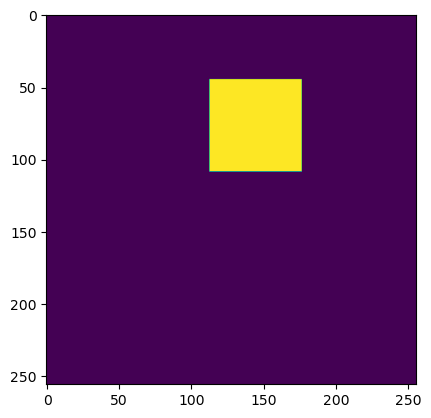

Tensor("Shape_1:0", shape=(2,), dtype=int32)


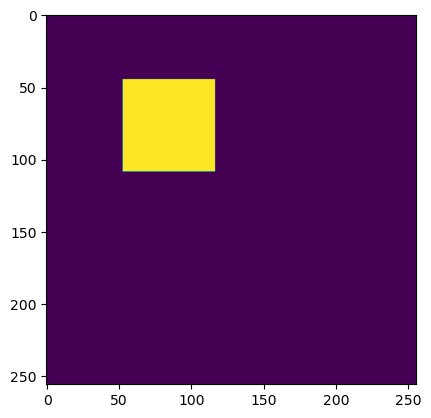

Tensor("Shape_2:0", shape=(2,), dtype=int32)


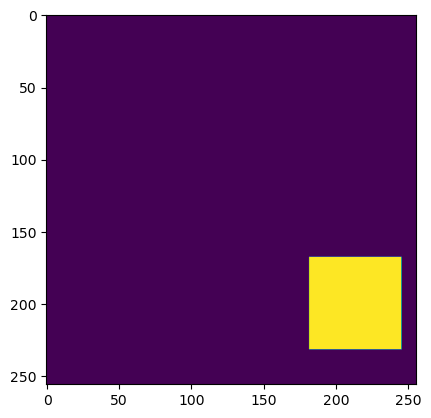

Tensor("Shape_3:0", shape=(2,), dtype=int32)


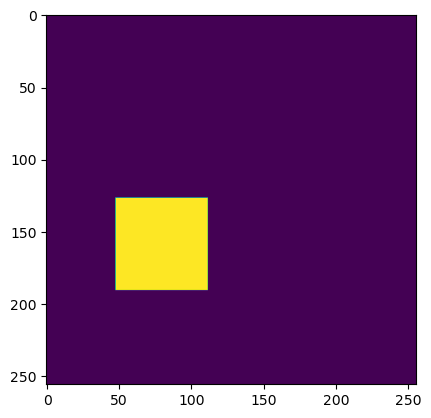

Tensor("Shape_4:0", shape=(2,), dtype=int32)


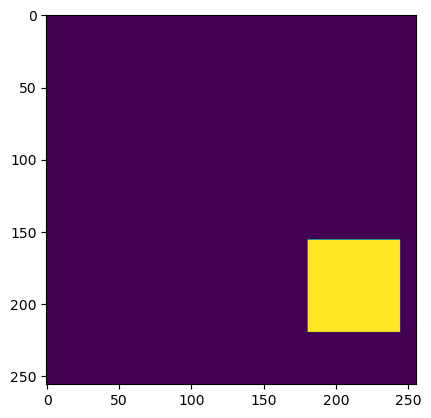

Tensor("Shape_5:0", shape=(2,), dtype=int32)


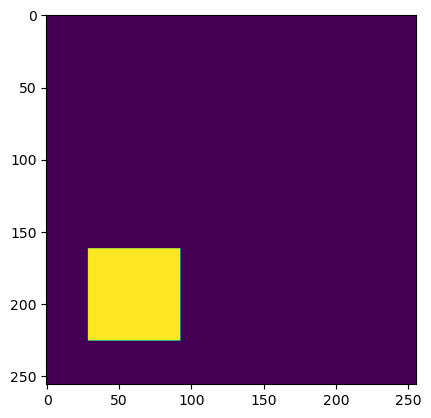

Tensor("Shape_6:0", shape=(2,), dtype=int32)


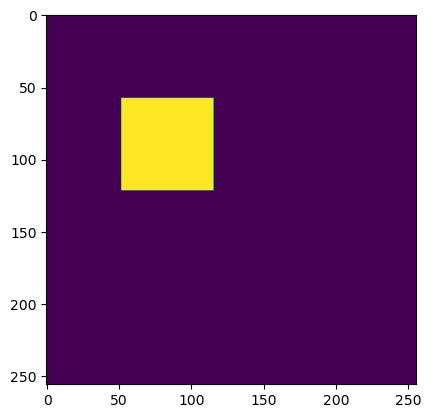

Tensor("Shape_7:0", shape=(2,), dtype=int32)


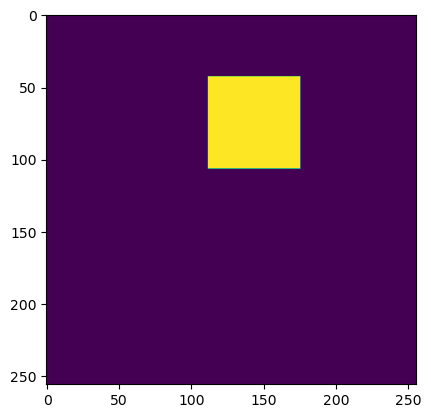

Tensor("Shape_8:0", shape=(2,), dtype=int32)


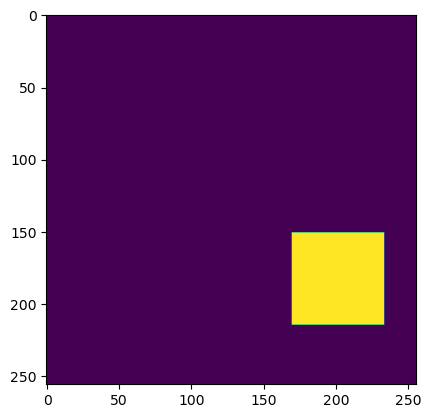

Tensor("Shape_9:0", shape=(2,), dtype=int32)


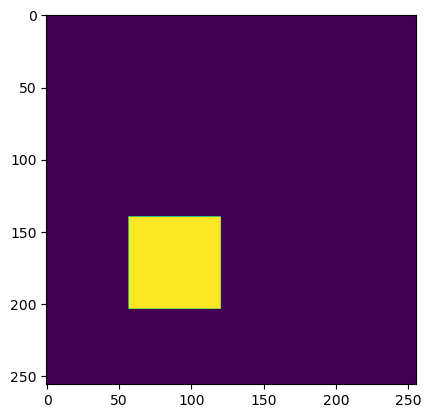

Tensor("Shape_10:0", shape=(2,), dtype=int32)


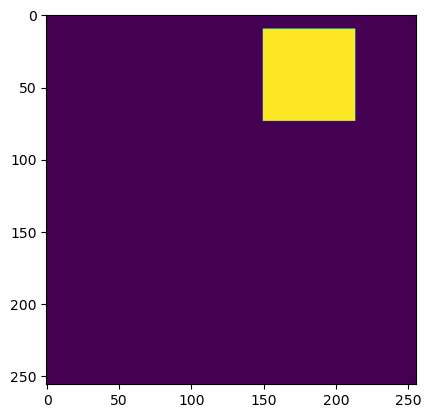

Tensor("Shape_11:0", shape=(2,), dtype=int32)


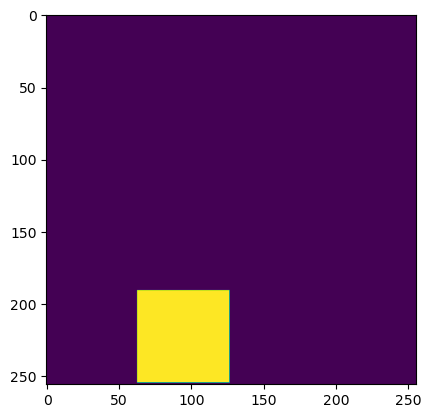

Tensor("Shape_12:0", shape=(2,), dtype=int32)


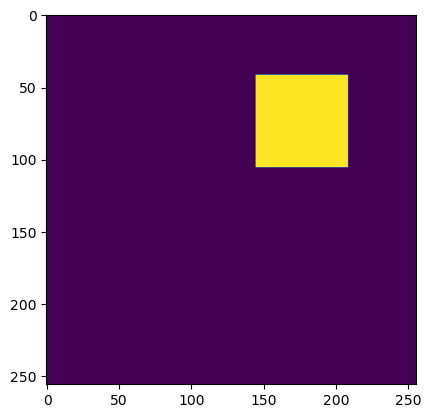

Tensor("Shape_13:0", shape=(2,), dtype=int32)


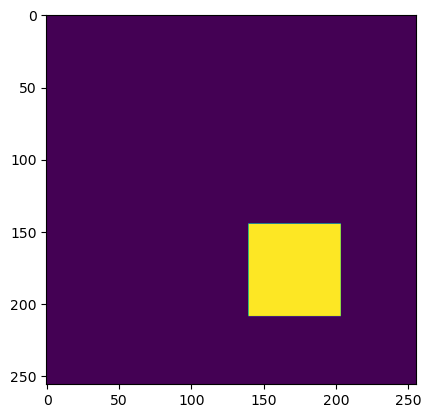

Tensor("Shape_14:0", shape=(2,), dtype=int32)


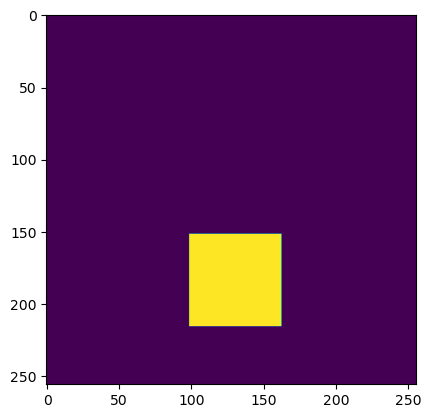

Tensor("Shape_15:0", shape=(2,), dtype=int32)


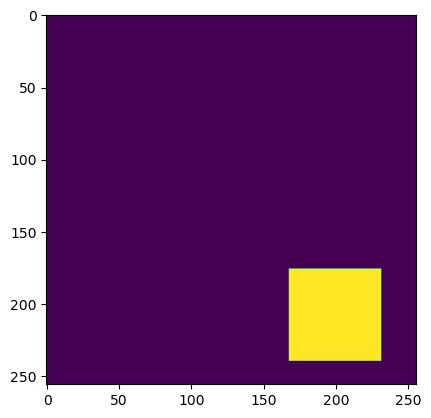

loading error: /kaggle/input/train-test-set/val_256/Places365_val_00022506.jpgTensor("Shape_16:0", shape=(2,), dtype=int32)



KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [9]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as T
import tensorflow as tf
# from .dataset import Dataset
# from .models import EdgeModel, InpaintingModel
# from .utils import Progbar, create_dir, stitch_images, imsave
# from .metrics import PSNR, EdgeAccuracy


class EdgeConnect():
    def __init__(self, config):
        self.config = config
        self.train_dataset = Dataset(256, '/kaggle/input/train-test-set/val_256', augment=True, training=True)
        train_loader = DataLoader(
            dataset=self.train_dataset,
            batch_size=self.config.BATCH_SIZE,
            num_workers=4,
            drop_last=True,
            shuffle=True
        )
        transform = T.ToPILImage()
        for items in train_loader:
            images, images_gray, edges, masks = items
            images = masks[0,...]
            images = images[0,...]
            print(tf.shape(images))
            arr_ = np.squeeze(images) # you can give axis attribute if you wanna squeeze in specific dimension
            plt.imshow(arr_)
            plt.show()
            
config = Config()            
edgeConnect = EdgeConnect(config)

In [ ]:
import tensorflow as tf

for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
init = tf.compat.v1.global_variables_initializer()
sess.run(init)